# Survival SymReg - Proportional Hazards

This notebook explores how to implement proportional hazards models with symbolic regression (with GPLearn). This is a pre-requisite to doing it with SHAREs. 

We don't yet consider allowing time interactions (non-proportional hazards) as this needs further modification of the `SymbolicRegressor` to allow time "through". 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("whitegrid")

## 0. Test Data

We load the example Rossi dataset from `lifelines`, on which Cox PH achieves C-index of ~0.64.

In [2]:
from datasets import Rossi, Metabric, GBSG2


# Test dataset - Cox achieves C-index of 0.6403292470997135
X, T, E = Rossi.load(normalise=True)
feature_names = Rossi.features
calibration_time = Rossi.tmax

# Test dataset - Cox achieves C-index of 0.6391503770136181
# X, T, E = Metabric.load(normalise=True)
# feature_names = Metabric.features
# calibration_time = Metabric.tmax

# Test dataset - Cox achieves C-index of 0.5437638695233794
# X, T, E = GBSG2.load(normalise=True)
# feature_names = GBSG2.features
# calibration_time = GBSG2.tmax

## 1. Baseline Model - Cox PH

We fit a standard Cox PH as the model to beat. 

In [108]:
from lifelines import CoxPHFitter
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score

X_df = pd.DataFrame(X, columns=feature_names).assign(time=T, event=E)
cph = CoxPHFitter()
cph.fit(X_df, duration_col="time", event_col="event")
cph.print_summary()

# Double check the concordance
from lifelines.utils import concordance_index

c_index = concordance_index(T, -cph.predict_partial_hazard(X), E)
y, t = Surv.from_arrays(E, T), np.unique(T).astype(float)[1:-1]
ibs = integrated_brier_score(y, y, cph.predict_survival_function(X, times=t).T, t)
print(f"C-index: {c_index}")
print(f"IBS: {ibs}")    

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-05-05 22:33:32 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.19      0.83      0.10           -0.38           -0.00                0.69                1.00
age       -0.35      0.70      0.13           -0.61           -0.09                0.54                0.92
race       0.10      1.11      0.10           -0.10            0.30                0.91                1.35
wexp      -0.07      0.93      0.11           -0.28            0.13                0.76                1.14
mar       -0.14      0.87      0.13           -0.39            0.10                0.68                1.11
paro      -0.04      0.96      0.10           -0.23            0.15                0.80                1.16
prio       0.26      1.30      0.08            0.10            0.43                1.11                1.53

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

C-index: 0.6403292470997135
IBS: 0.09467578840277145


## 2. Fitness Metrics
There are 3 options: 
 - The concordance (c-index) 
 - The DeepSurv/CoxTime ranking loss
 - The Cox partial likelihood (very similar)

DeepSurv/CoxTime also includes a shrink penalty in its loss to penalise the neural networks $g(t|x)$ from having values too far from 0. 

`gplearn` fitness functions normally depend only on `y_true` and `y_pred`, but we also require the event/censoring indicator. We pass the indicator as the `sample_weight` as a workaround to avoid modifying `gplearn` yet. 

In [4]:
# C-index
from lifelines.utils import concordance_index
from gplearn_clean.gplearn.fitness import make_fitness
from sklearn.metrics import make_scorer
import warnings

def metric_c_index(y_true, y_pred, sample_weight):
    """
    Protected concordance score metric for gplearn. Greater is better.
    """
    # y_true is the event time, y_pred is the predicted risk
    # sample_weight is the event indicator
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        try:
            return concordance_index(y_true, np.exp(y_pred), sample_weight)
        except ZeroDivisionError:  # In case of no unambigous pairs
            return 0.5
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return 0.5

scorer_c_index = make_scorer(metric_c_index, greater_is_better=True)

In [5]:
def metric_ranking_loss(y_true, y_pred, sample_weight):
    """
    Ranking loss metric for gplearn (similar to DeepSurv and CoxTime). Less is better.
    """
    # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
    # Inputs must be sorted by descending event time
    ordering = np.argsort(y_true)[::-1]
    y_true = y_true[ordering]
    y_pred = pd.Series(y_pred[ordering])
    sample_weight = pd.Series(sample_weight[ordering])

    gamma = y_pred.max()
    eps = 1e-7

    try:
        log_cumsum_h = np.log(np.exp(y_pred.sub(gamma)).cumsum(0).add(eps)).add(gamma)
        pll = y_pred.sub(log_cumsum_h).mul(sample_weight).sum() / sample_weight.sum()
        return -pll  # Flip the sign to make it a minimization function
    except RuntimeWarning:  # In case of invalid log or exp overflow
        return np.inf

In [6]:
from pycox.evaluation.metrics import partial_log_likelihood_ph

def metric_partial_likelihood(y_true, y_pred, sample_weight):
    """
    Cox partial likelihood metric for gplearn. Less is better.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        # We want to minimise the negative partial log likelihood
        # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
        try:
            pll = partial_log_likelihood_ph(y_pred, y_true, sample_weight, mean=True)
            return -pll  # Flip the sign to make it a minimization function
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return np.inf

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score
def metric_integrated_brier(surv_pred, E_train, T_train, E_test=None, T_test=None):
    """
    Integrated Brier score for pycox-type models
    """
    E_test = E_test if E_test is not None else E_train 
    T_test = T_test if T_test is not None else T_train

    y_train, y_test = Surv.from_arrays(E_train, T_train), Surv.from_arrays(E_test, T_test)

    times = surv_pred.index.values[1:-1]
    times = times[(times > T_test.min()) & (times < T_test.max())]
    surv_pred = surv_pred.loc[times, :].T

    return integrated_brier_score(y_train, y_test, surv_pred, times)

In [142]:
# Testing with Cox PH
h_pred = cph.predict_partial_hazard(X)
surv_pred = cph.predict_survival_function(X)
print(f"C-index: {metric_c_index(T, -h_pred, E)}")
print(f"Ranking loss: {metric_ranking_loss(T, h_pred, E)}")
print(f"Partial likelihood: {metric_partial_likelihood(T, h_pred, E)}")
print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

C-index: 0.6403292470997135
Ranking loss: 5.133125475631877
Partial likelihood: 5.985998659506427
IBS: 0.09467578840277145


## 3. Other Estimands - $h_0$, $H$, and $S$

Given our predicted $h(t|x)$, we also need to obtain the baseline $h_0$ (which also depends on our fitted $h$), cumulative hazards $H(t|x)$ and $H_0(t|x)$, and finally the survival $S(t|x)$. 

The ways to obtain these are standardised irrespective of if we used Cox or SymReg for $h$.

<Axes: title={'center': '$S(t|x^*)$'}>

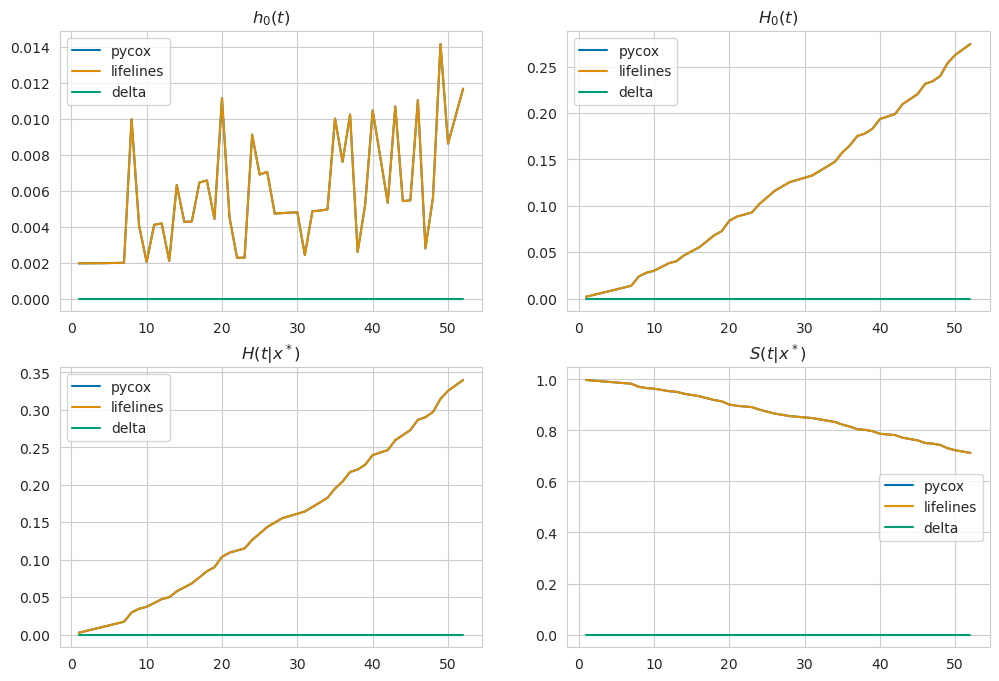

In [8]:
from pycox.models.cox import _CoxPHBase
import torchtuples as tt

class CustomPH(_CoxPHBase):
    def __init__(self, *args, **kwargs):
        pass

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return np.log(cph.predict_partial_hazard(X).to_numpy())

cc = CustomPH()

# This must run & store results in the cc object before predict_cumulative_hazards can run
h0_pred = cc.compute_baseline_hazards(X, (T, E))
h0_true = cph.baseline_hazard_["baseline hazard"]

H0_pred = cc.compute_baseline_cumulative_hazards(X, (T, E))
H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]

H_pred = cc.predict_cumulative_hazards(X[5:6])[0]  # For a random row in X
H_true = cph.predict_cumulative_hazard(X[5:6])[0]

S_pred = cc.predict_surv(X[5:6])[0]  # For a random row in X
S_true = cph.predict_survival_function(X[5:6])[0]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = np.ravel(ax)

pd.DataFrame(dict(pycox=h0_pred, lifelines=h0_true, delta=h0_pred - h0_true)).plot(
    ax=ax[0], title="$h_0(t)$"
)
pd.DataFrame(dict(pycox=H0_pred, lifelines=H0_true, delta=H0_pred - H0_true)).plot(
    ax=ax[1], title="$H_0(t)$"
)
pd.DataFrame(dict(pycox=H_pred, lifelines=H_true, delta=H_pred - H_true)).plot(
    ax=ax[2], title="$H(t|x^*)$"
)
pd.DataFrame(dict(pycox=S_pred, lifelines=S_true, delta=S_pred - S_true)).plot(
    ax=ax[3], title="$S(t|x^*)$"
)

### 3.1 Survival Estimands for `SymbolicRegressor`

We piggy-back off `pycox` and use their code for the above estimands. We wrap `SymbolicRegressor` in a child class of `_CoxPHBase` to do this. 

In [ ]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt


class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, **kwargs):
        self.model = SymbolicRegressor(**kwargs)

    def fit(self, X, y, sample_weight, *args, **kwargs):
        self.model.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict(X)

    def score(self, X, y, sample_weight, *args, **kwargs):
        y_pred = self.predict(X)
        return concordance_index(y, y_pred, sample_weight)

    def silent(self):
        return self.model.set_params(verbose=False)

In [129]:
class EvalSymRegPH:
    def __init__(self, model):
        self.model = model

    def score(self, X, T, E, sign=1):
        y_pred = sign * self.model.predict(X)
        surv_pred = self.model.predict_surv_df(X)
        print(f"C-index: {concordance_index(T, y_pred, E)}")
        print(f"Ranking loss: {metric_ranking_loss(T, y_pred, E)}")
        print(f"Partial likelihood: {metric_partial_likelihood(T, y_pred, E)}")
        print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

    def plot_estimands(self, X, T, E, h0_scale_factor=1):
        # This must run & store results in the symreg_cidx object before predict_cumulative_hazards can run
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        h0_pred_scaled = h0_pred * h0_scale_factor
        h0_true = cph.baseline_hazard_["baseline hazard"]
        h0_corr = h0_pred.corr(h0_true, method="pearson")

        H0_pred = self.model.compute_baseline_cumulative_hazards(
            baseline_hazards_=h0_pred_scaled
        )
        H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]
        H0_corr = H0_pred.corr(H0_true, method="pearson")

        # Select a random row in X
        idx = np.random.randint(0, len(X) - 1)
        X_star = X[idx : idx + 1]

        H_pred = self.model.predict_cumulative_hazards(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        H_true = cph.predict_cumulative_hazard(X_star)[0]
        H_corr = H_pred.corr(H_true, method="pearson")

        S_pred = self.model.predict_surv(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        S_true = cph.predict_survival_function(X_star)[0]
        S_corr = pd.Series(S_pred).corr(S_true, method="pearson")

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax = np.ravel(ax)

        h0_dict = dict(symreg=h0_pred, cox=h0_true, delta=h0_pred_scaled - h0_true)
        if h0_scale_factor != 1:
            h0_dict["symreg_scaled"] = h0_pred_scaled

        pd.DataFrame(h0_dict).plot(ax=ax[0], title=f"$h_0(t)$ - corr={h0_corr:.2f}")
        pd.DataFrame(dict(symreg=H0_pred, cox=H0_true, delta=H0_pred - H0_true)).plot(
            ax=ax[1], title=f"$H_0(t)$ - corr={H0_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=H_pred, cox=H_true, delta=H_pred - H_true)).plot(
            ax=ax[2], title=f"$H(t|x^*)$ - corr={H_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=S_pred, cox=S_true, delta=S_pred - S_true)).plot(
            ax=ax[3], title=f"$S(t|x^*)$ - corr={S_corr:.2f}"
        )

## 4. SymReg with Concordance

We train GPLearn with the (safe) concordance as the fitness function. This is a relative ranking metric & thus is scale- and shift-invariant, so we expect to get poor absolute risk predictions (bad calibration) but good rankings. 

I.e., the predicted hazards will be on the wrong scale & may be shifted. 

This has knock-on effects on numerical instability of downstream survival estimands like $H_0$. The calibration is therefore poor.

In [11]:
fitness_c_index = make_fitness(function=metric_c_index, greater_is_better=True)

symreg_c = SymRegPH(
    metric=fitness_c_index,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient="auto",
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_c.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.52         0.506527        3         0.628458              N/A     13.16s
   1     9.48         0.548355       17         0.642114              N/A     13.04s
   2     8.00         0.580698       17         0.642114              N/A     13.14s
   3     8.56         0.601403       19         0.654373              N/A     12.88s
   4     8.61         0.617347       21         0.650756              N/A     12.21s
   5     7.96         0.617961       23         0.653903              N/A     11.34s
   6    10.80         0.608781       27         0.653692              N/A     10.57s
   7    18.78         0.605655       37         0.655805              N/A     10.19s
   8    20.25         0.602754       29         0.656017              N/A  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x148824673e50>,
                  parsimony_coefficient='auto', population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.658447231224461
Ranking loss: 13.978960660587337
Partial likelihood: 14.020185020710008


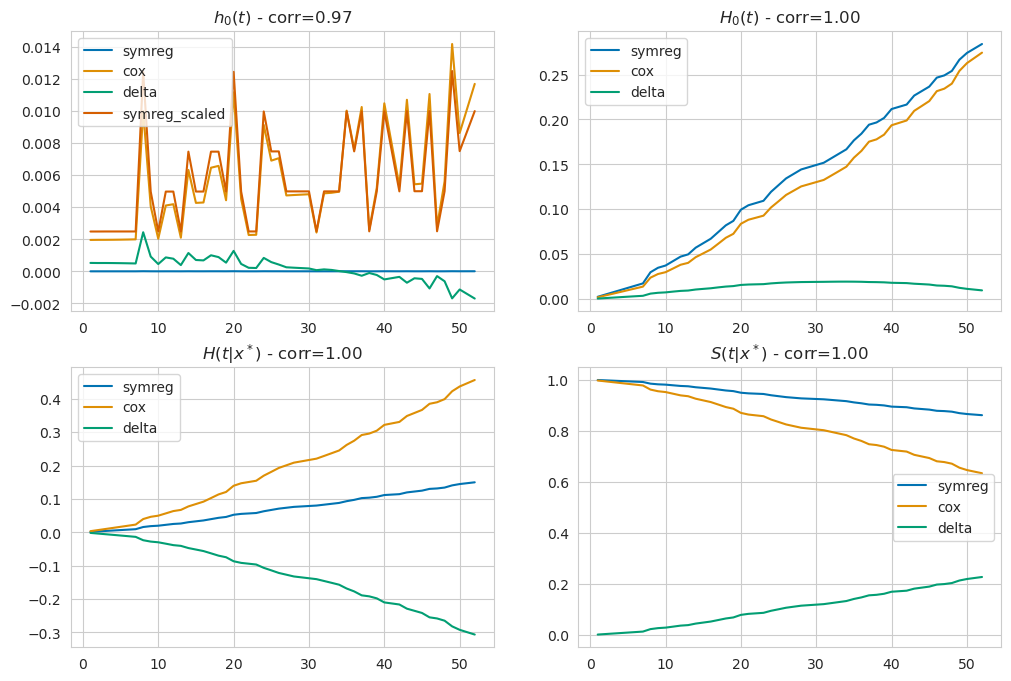

In [30]:
EvalSymRegPH(symreg_c).score(X, T, E)
EvalSymRegPH(symreg_c).plot_estimands(X, T, E, h0_scale_factor=1600)

In [13]:
# Can't use `cross_validate` bc it won't pass the event indicators properly
# so we write a custom CV loop
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import time


class SurvivalCV:
    def __init__(self, model, score, sign=1):
        self.model = model
        self.score = score
        self.sign = sign

    @staticmethod
    def cv_fold(model, X, T, E, score, idx_train, idx_test, sign=1):
        fit_time_start = time.time()
        model.fit(X[idx_train], T[idx_train], sample_weight=E[idx_train])
        fit_time_stop = time.time()

        score_train, score_test = (
            score(T[idx_train], sign * model.predict(X[idx_train]), E[idx_train]),
            score(T[idx_test], sign * model.predict(X[idx_test]), E[idx_test]),
        )

        return fit_time_stop - fit_time_start, score_train, score_test

    def cross_validate(self, X, T, E, cv=5, n_jobs=-1):
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)

        results = Parallel(n_jobs=n_jobs)(
            delayed(self.cv_fold)(
                self.model, X, T, E, self.score, train_idx, test_idx, self.sign
            )
            for train_idx, test_idx in kf.split(X)
        )

        fit_times, train_scores, test_scores = zip(*results)
        print(f"Mean fit time: {np.mean(fit_times):.4f}s")
        print(f"Train C: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
        print(f"Test C: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")

        return results

/rds/user/sb2690/hpc-work/SHAREs/plot.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.38630516053021113
E50 =  0.2917358694159582


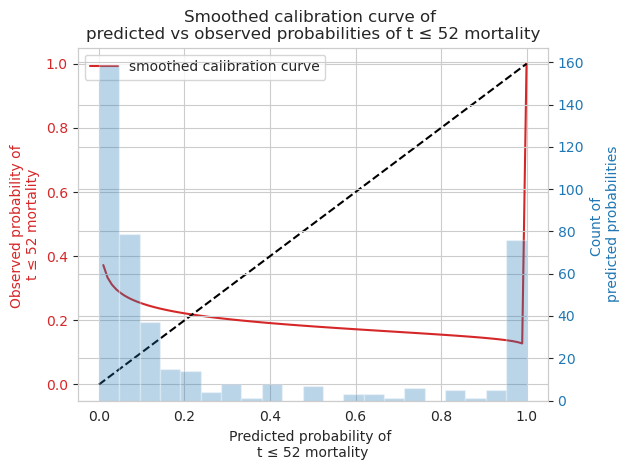

In [14]:
from plot import survival_probability_calibration

surv_pred = symreg_c.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)

In [15]:
cv_results_c = SurvivalCV(symreg_c.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

Mean fit time: 13.9635s
Train C: 0.6641 ± 0.0153
Test C: 0.5875 ± 0.0362


### 4.1 Shrink Penalty

We add a shrink penalty to the fitness function to encourage estimated $h$ values near $0$. This fixes the "scaling" issue. However, the calibration remains rubbish.

In [16]:
def fitness_c_shrink(y_true, y_pred, sample_weight):
    """
    Concordance index with shrink penalty for gplearn. Greater is better.
    """
    return metric_c_index(y_true, y_pred, sample_weight) - 0.05 * np.abs(y_pred).mean()


fitness_c_shrink = make_fitness(function=fitness_c_shrink, greater_is_better=True)

symreg_cs = SymRegPH(
    metric=fitness_c_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.0,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_cs.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.24         -9.96706        5         0.576663              N/A     13.24s
   1     5.38         0.494918        5         0.576663              N/A     11.92s
   2     3.33         0.535964        3         0.599588              N/A     11.25s
   3     4.05         0.540174        7         0.608285              N/A      9.88s
   4     4.24           0.5706        5         0.608452              N/A     10.15s
   5     4.95         0.216232        9         0.612933              N/A      9.56s
   6     6.99         0.584942       13         0.613543              N/A      8.98s
   7    10.60         0.589334       23         0.613639              N/A      8.33s
   8    17.61         0.590432       37          0.61364              N/A  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x148822c3cf10>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.6214010614813771
Ranking loss: 5.903286161186309
Partial likelihood: 5.927047275592718


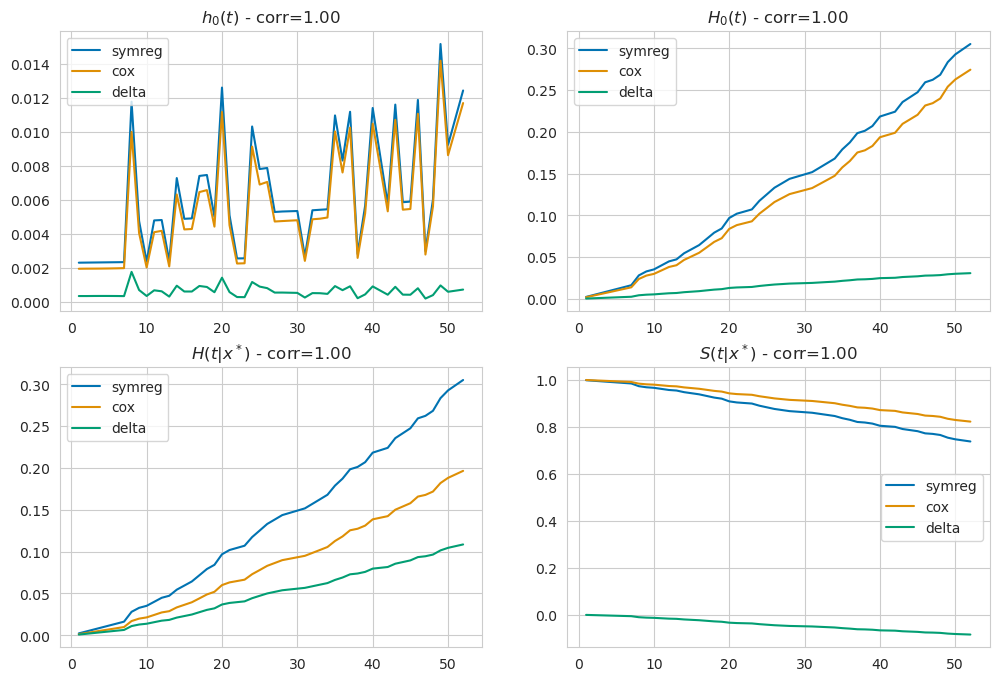

In [17]:
EvalSymRegPH(symreg_cs).score(X, T, E)
EvalSymRegPH(symreg_cs).plot_estimands(X, T, E)  # No scaling factor required

ICI =  0.0009613304636189487
E50 =  0.0009613304634755737


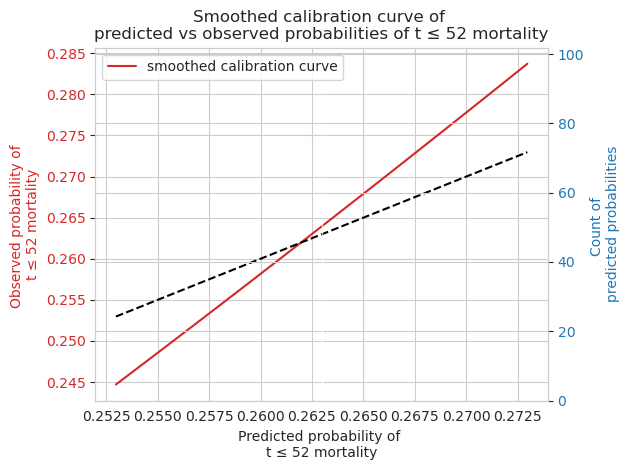

In [18]:
from plot import survival_probability_calibration

surv_pred = symreg_cs.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)

In [19]:
cv_results_cs = SurvivalCV(symreg_cs.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

Mean fit time: 14.5037s
Train C: 0.6731 ± 0.0178
Test C: 0.5828 ± 0.0287


## 5. SymReg with Log-Partial Likelihood Loss

This yields good discrimination and calibration. 

In [20]:
def fitness_pll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = metric_partial_likelihood(y_true, y_pred, sample_weight)
    return pll + 0.05 * np.abs(y_pred).mean()


fitness_pll_shrink = make_fitness(
    function=fitness_pll_shrink, greater_is_better=False
)

symreg_rl = SymRegPH(
    metric=fitness_pll_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.00,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_rl.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    28.97              inf        7          5.90389              N/A     18.44s
   1     7.74              inf        5          5.87601              N/A     18.45s
   2     7.76              inf        5          5.87601              N/A     17.32s
   3     6.16          7.10831       13          5.84905              N/A     16.35s
   4     6.66          6.49554        9          5.83867              N/A     15.01s
   5     8.44          6.66092        9          5.83867              N/A     14.00s
   6    10.53          6.25957       17           5.8258              N/A     13.02s
   7    12.98           6.2616       17          5.81876              N/A     12.02s
   8    16.46           6.2598       21          5.81621              N/A  

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x148823c07d00>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.6612770654267062
Ranking loss: 6.848259769547966
Partial likelihood: 6.875004307364988


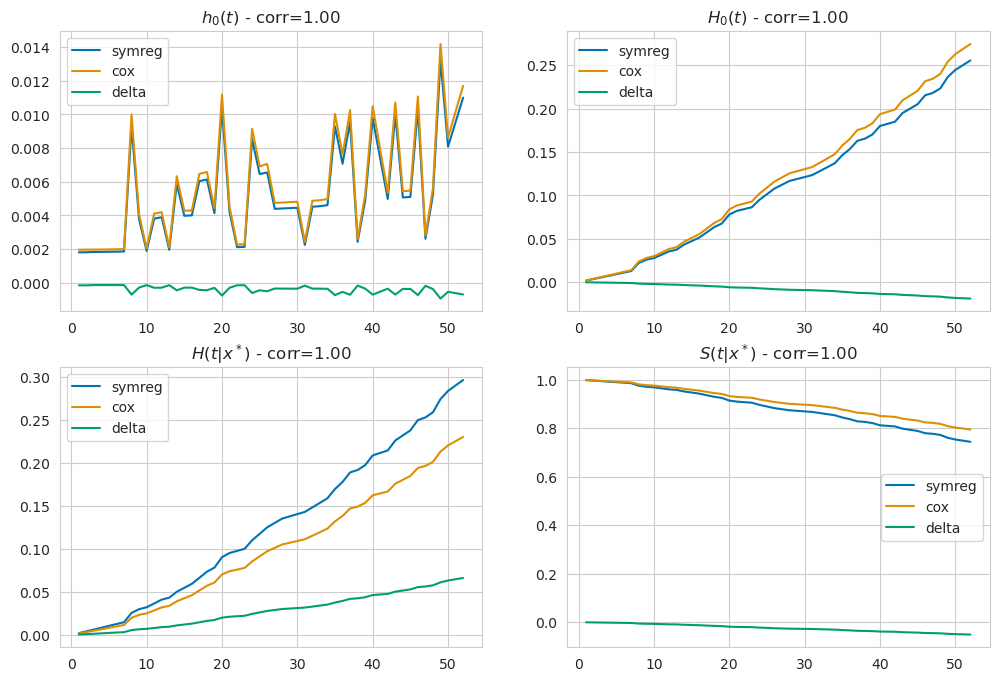

In [21]:
EvalSymRegPH(symreg_rl).score(X, T, E, sign=-1)
EvalSymRegPH(symreg_rl).plot_estimands(X, T, E)  # No scaling factor required

In [22]:
cv_results_rl = SurvivalCV(symreg_rl.silent(), metric_c_index, sign=-1).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

Mean fit time: 20.7282s
Train C: 0.6407 ± 0.0254
Test C: 0.5623 ± 0.0196


/rds/user/sb2690/hpc-work/SHAREs/plot.py:42: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))


ICI =  0.027797290598330054
E50 =  0.02163191428708322


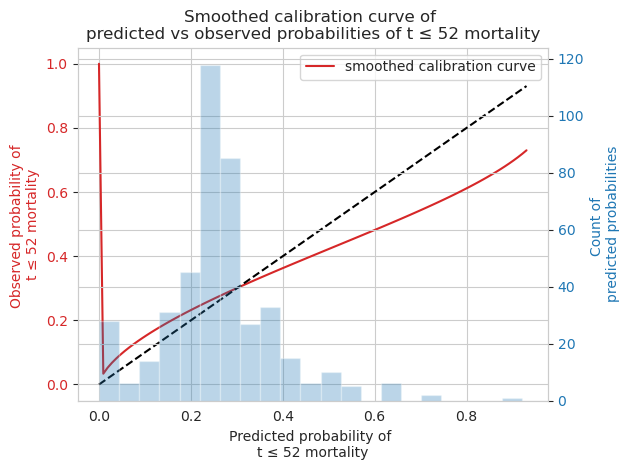

In [23]:
from plot import survival_probability_calibration

surv_pred = symreg_rl.predict_surv_df(X)
fig = survival_probability_calibration(surv_pred, T, E, t0 = calibration_time)